### 経済センサスデータを用いた簡易住宅地地価予測

In [ ]:
!python -m pip install pandas geopandas contextily matplotlib pygeos scikit-learn

In [134]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [119]:
# 経済センサスメッシュデータの準備
mesh = gpd.read_file('data/HDDSWH5339/MESH05339.shp', crs=4612).to_crs(2451)
mesh = mesh[['KEY_CODE', 'geometry']]
mesh.KEY_CODE = mesh.KEY_CODE.astype(str)
keizai = pd.read_csv("data/tblT000389H5339.txt", encoding='sjis', skiprows=1)
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai_mesh = pd.merge(mesh, keizai, on='KEY_CODE')

In [142]:
# 公示地価データの準備
chika = gpd.read_file('data/tokyo-koji/L01-22_13.shp', crs=4612).to_crs(2451)
chika = chika[(chika.L01_027 == '住宅') & (chika.L01_049 > 700) & (chika.L01_049 < 1300)]
chika = chika[['L01_006', 'L01_026', 'L01_049', 'geometry']]
chika.columns = ['price', 'menseki', 'station', 'geometry']
chika['p10'] = np.log10(chika.price)
chika['tokyo'] = chika.geometry.distance(keizai_mesh.sort_values('people', ascending=False).geometry.values[0])

-1.795770267547336e-05 5.851200279045939
0.7063397529935713


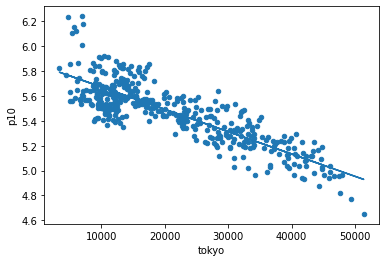

In [143]:
# 公示地価データを用いた簡易地価予測モデル作成（大手町駅からの距離を用いて）
ax = chika.plot(x='tokyo', y='p10', kind='scatter')
a, b = np.polyfit(chika.tokyo, chika.p10, 1)
print(a, b)
ax.plot(chika.tokyo, a * chika.tokyo + b)
r2 = metrics.r2_score(chika.p10, a * chika.tokyo + b)
print(r2)
plt.show()

<AxesSubplot:>

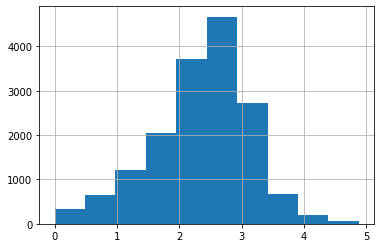

In [121]:
x = pd.Series(np.log10(keizai_mesh.people, where=keizai_mesh.people>0))
x[x > 0].hist()

In [122]:
# 従業者数が多いメッシュからの距離を加重平均して変数とする
chikap = chika.copy()
ans = []
keizai2 = keizai_mesh[keizai_mesh.people > 7500]
for row in chikap.geometry:
    x = []
    for g, p in zip(keizai2.geometry.centroid, keizai2.people):
        x.append(p / ((row.distance(g) ** 1.5) + 250))
    ans.append(sum(x))
chikap['keizai'] = ans
chikap['keizai10'] = np.log10(chikap.keizai)
chikap.sort_values('keizai10', ascending=False)

,price,menseki,station,geometry,p10,keizai,keizai10
830,1420000,137,750,POINT (-11633.832 -37317.765),6.152288,30.918865,1.490224
820,1320000,249,900,POINT (-10461.234 -39498.025),6.120574,20.162572,1.304546
836,1270000,297,1100,POINT (-10654.077 -38324.527),6.103804,20.003038,1.301096
831,1740000,304,900,POINT (-12443.085 -38511.422),6.240549,19.051738,1.279935
145,1730000,380,760,POINT (-9114.738 -38911.946),6.238046,18.952369,1.277664
...,...,...,...,...,...,...,...
2511,66100,121,1200,POINT (-53810.837 -30068.397),4.820201,0.511041,-0.291544
1863,90100,193,1100,POINT (-52516.111 -23680.614),4.954725,0.499394,-0.301557
1883,92300,165,950,POINT (-52847.847 -23009.706),4.965202,0.489807,-0.309975
1884,59000,165,1200,POINT (-54581.210 -23935.026),4.770852,0.468296,-0.329480


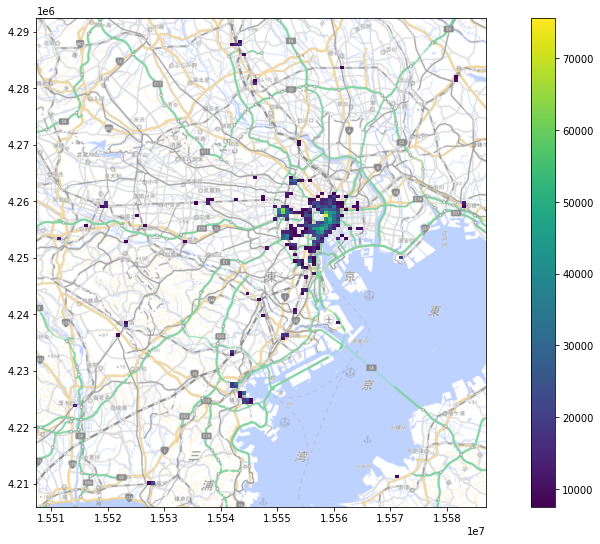

In [133]:
ax = keizai_mesh[keizai_mesh.people > 7500].to_crs(3857).plot('people', figsize=(16, 9), legend=True)
cx.add_basemap(ax, source='https://cyberjapandata.gsi.go.jp/xyz/pale/{z}/{x}/{y}.png')

0.680326176769457 5.234012814871473
0.8113709995882489


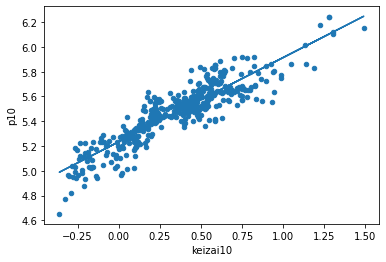

In [145]:
# 予測モデル作成
th = 4
ax = chikap[chikap.keizai10 < th].plot(x='keizai10', y='p10', kind='scatter')
x = chikap[chikap.keizai10 < th].keizai10
y = chikap[chikap.keizai10 < th].p10
a, b = np.polyfit(x, y, 1)
print(a, b)
ax.plot(x, a * x + b)
r2 = metrics.r2_score(y, a * x + b)
print(r2)
plt.show()

In [124]:
# 京王線の駅の住宅地価を予測してみる
keio = gpd.read_file('data/station.geojson', crs=4612).query('N02_003 == "京王線"').iloc[:, 4:].to_crs(2451)
keio.columns = ['station', 'geometry']
keio['tokyo'] = keio.geometry.distance(keizai_mesh.sort_values('people', ascending=False).geometry.values[0])
keio = keio.sort_values('tokyo')
keio.head(5)

,station,geometry,tokyo
633,新宿,"LINESTRING (-12129.235 -34527.801, -12256.936 ...",5719.897684
627,新宿,"LINESTRING (-12142.544 -34332.524, -12135.450 ...",5728.928068
631,初台,"LINESTRING (-13098.813 -35304.132, -13162.266 ...",6689.684138
623,幡ヶ谷,"LINESTRING (-14041.922 -35835.216, -14130.682 ...",7663.027808
622,笹塚,"LINESTRING (-14976.664 -36168.736, -15106.197 ...",8627.998905


In [125]:
ans = []
keizai2 = keizai_mesh[keizai_mesh.people > 7500]
for row in keio.geometry:
    x = []
    for g, p in zip(keizai2.geometry.centroid, keizai2.people):
        x.append(p / ((row.distance(g) ** 1.5) + 250))
    ans.append(sum(x))
keio['keizai'] = np.log10(ans)
keio.head(10)

,station,geometry,tokyo,keizai
633,新宿,"LINESTRING (-12129.235 -34527.801, -12256.936 ...",5719.897684,1.749245
627,新宿,"LINESTRING (-12142.544 -34332.524, -12135.450 ...",5728.928068,1.724989
631,初台,"LINESTRING (-13098.813 -35304.132, -13162.266 ...",6689.684138,1.319245
623,幡ヶ谷,"LINESTRING (-14041.922 -35835.216, -14130.682 ...",7663.027808,1.062682
622,笹塚,"LINESTRING (-14976.664 -36168.736, -15106.197 ...",8627.998905,0.922069
621,代田橋,"LINESTRING (-15686.879 -36452.634, -15805.563 ...",9369.278726,0.841735
630,明大前,"LINESTRING (-16495.863 -36760.700, -16538.439 ...",10215.426754,0.765163
628,下高井戸,"LINESTRING (-17414.343 -37014.117, -17391.718 ...",10977.514666,0.705773
624,桜上水,"LINESTRING (-18198.973 -36869.430, -18351.912 ...",11915.193816,0.642057
629,上北沢,"LINESTRING (-19074.973 -36705.619, -18932.900 ...",12623.752116,0.599557


In [149]:
keio['pred_keizai'] = (10 ** (0.68 * keio.keizai + 5.234) * 3.30579).astype(int) / 10000
keio['pred_tokyo'] = (10 ** (-0.0000179577 * keio.tokyo + 5.85) * 3.30579).astype(int) / 10000
keio

,station,geometry,tokyo,keizai,pred,pred_keizai,pred_tokyo
633,新宿,"LINESTRING (-12129.235 -34527.801, -12256.936 ...",5719.897684,1.749245,876.5204,876.5204,184.7391
627,新宿,"LINESTRING (-12142.544 -34332.524, -12135.450 ...",5728.928068,1.724989,843.8544,843.8544,184.6702
631,初台,"LINESTRING (-13098.813 -35304.132, -13162.266 ...",6689.684138,1.319245,447.0561,447.0561,177.4777
623,幡ヶ谷,"LINESTRING (-14041.922 -35835.216, -14130.682 ...",7663.027808,1.062682,299.1568,299.1568,170.4766
622,笹塚,"LINESTRING (-14976.664 -36168.736, -15106.197 ...",8627.998905,0.922069,240.0392,240.0392,163.8084
621,代田橋,"LINESTRING (-15686.879 -36452.634, -15805.563 ...",9369.278726,0.841735,211.6677,211.6677,158.8636
630,明大前,"LINESTRING (-16495.863 -36760.700, -16538.439 ...",10215.426754,0.765163,187.7527,187.7527,153.4015
628,下高井戸,"LINESTRING (-17414.343 -37014.117, -17391.718 ...",10977.514666,0.705773,171.0807,171.0807,148.6429
624,桜上水,"LINESTRING (-18198.973 -36869.430, -18351.912 ...",11915.193816,0.642057,154.8368,154.8368,142.9900
629,上北沢,"LINESTRING (-19074.973 -36705.619, -18932.900 ...",12623.752116,0.599557,144.8686,144.8686,138.8614


In [150]:
keio[['station', 'pred_keizai', 'pred_tokyo']]

,station,pred_keizai,pred_tokyo
633,新宿,876.5204,184.7391
627,新宿,843.8544,184.6702
631,初台,447.0561,177.4777
623,幡ヶ谷,299.1568,170.4766
622,笹塚,240.0392,163.8084
621,代田橋,211.6677,158.8636
630,明大前,187.7527,153.4015
628,下高井戸,171.0807,148.6429
624,桜上水,154.8368,142.9900
629,上北沢,144.8686,138.8614
